## **PRACTICAL SESSION 1** — Deep Learning for predictive maintenance

The dataset used is the **AI4I 2020** Predictive Maintenance Dataset, which contains 10,000 instances of industrial sensor data. Each instance represents the operating condition of a machine and is associated with a label indicating whether a failure has occurred and, if so, what type of failure it is.

The 5 possible labels are:



*   **TWF**: Tool Wear Failure
*   **HDF**: Heat Dissipation Failure
*   **PWF**: Power Failure
*   **OSF**: Overstrain Failure
*   **RNF**: Random Failure


The data is available on eCAMPUS as CSV file called: "ai4i2020.csv"



## **PRACTICAL SESSION Goal** — Ceate a deep leanring model allowing to realize a predictive maintenance mission

## **1 - Analysis of the dataset**



All libraries used ***SHOULD BE PLACED*** in the code cell below

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import sklearn as sk
import numpy as np
#print(tf.__version__)
#print(pd.__version__)
#print(sk.__version__)

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dropout, ReLU

from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix

from imblearn.over_sampling import SMOTE
from sklearn.utils.class_weight import compute_class_weight


2.19.0
2.2.3
1.6.1


**QUESTION:** Load dataset and display some lines of the csv file.

In [4]:
# Load the dataset
df = pd.read_csv('./data/ai4i2020.csv')

# Display the first few lines of the dataset
print(df.head())

   UDI Product ID Type  Air temperature [K]  Process temperature [K]  \
0    1     M14860    M                298.1                    308.6   
1    2     L47181    L                298.2                    308.7   
2    3     L47182    L                298.1                    308.5   
3    4     L47183    L                298.2                    308.6   
4    5     L47184    L                298.2                    308.7   

   Rotational speed [rpm]  Torque [Nm]  Tool wear [min]  Machine failure  TWF  \
0                    1551         42.8                0                0    0   
1                    1408         46.3                3                0    0   
2                    1498         49.4                5                0    0   
3                    1433         39.5                7                0    0   
4                    1408         40.0                9                0    0   

   HDF  PWF  OSF  RNF  
0    0    0    0    0  
1    0    0    0    0  
2    0  

**QUESTION:** Display the distribution of machine failures and non-failures with a bar graph.

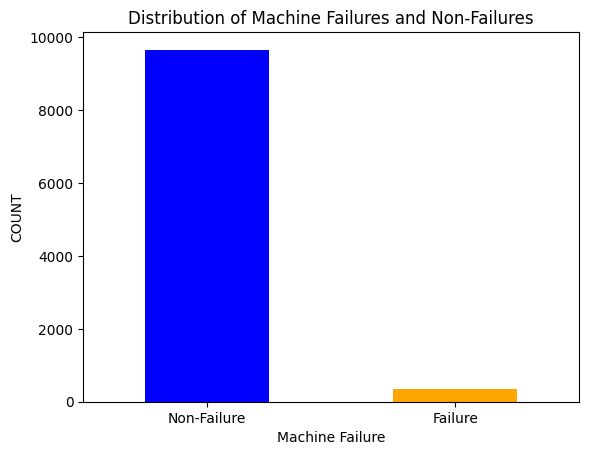

In [5]:
# Count the occurrences of machine failures and non-failures
failure_counts = df['Machine failure'].value_counts()

# Plot the bar graph
failure_counts.plot(kind='bar', color=['blue', 'orange'])
plt.title('Distribution of Machine Failures and Non-Failures')
plt.xlabel('Machine Failure')
plt.ylabel('COUNT')
plt.xticks(ticks=[0, 1], labels=['Non-Failure', 'Failure'], rotation=0)
plt.show()

**ANALYSIS QUESTION:** What do you observe?

Très peu de Machine Failure par rapport au non-failure.

**ANALYSIS QUESTION:** What will be the consequence of this phenomenon on the model's learning?

Peu de données d'entrainement sur les machine failure. Le modèle pourra peut etre manquer de données d'entrainement et aura du mal à prédire l'état des machines avec un nouveau dataset.

**QUESTION:** Create a bar chart showing the distribution of different failure types (TWF, HDF, PWF, OSF, RNF). Display the exact values above each bar in the chart.

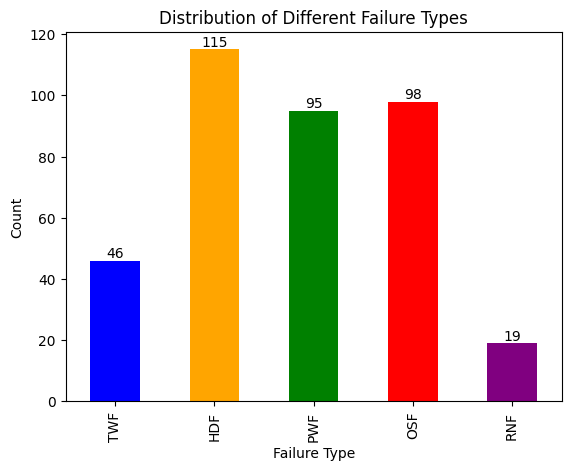

In [6]:
# Count the occurrences of each failure type
failure_types = df[['TWF', 'HDF', 'PWF', 'OSF', 'RNF']].sum()

# Plot the bar chart
ax = failure_types.plot(kind='bar', color=['blue', 'orange', 'green', 'red', 'purple'])
plt.title('Distribution of Different Failure Types')
plt.xlabel('Failure Type')
plt.ylabel('Count')

# Display the exact values above each bar
for i in ax.containers:
    ax.bar_label(i)

plt.show()

**ANALYSIS QUESTION:** What do you observe?

Les differents type de failure sont réparties inegalement. Le "RNF" est très rare, seulement 19 occurences sur les 10000 machines.

**QUESTION:** Create a bar chart showing the distribution of failure types (TWF, HDF, PWF, OSF, RNF) among machines that experienced a failure (Machine failure == 1). Additionally, add a "No Specific Failure" category to count cases where a machine failed but no specific failure type was recorded. Display the exact values above each bar in the chart."

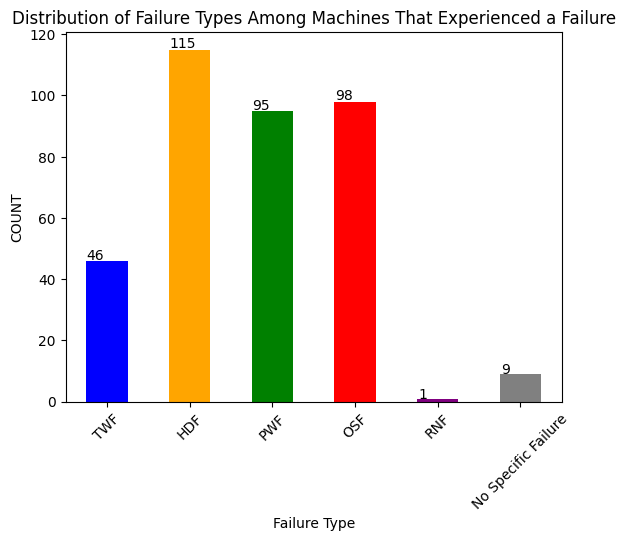

In [7]:
# Filter the dataframe for machines that experienced a failure
failure_df = df[df['Machine failure'] == 1]

# Count the occurrences of each failure type
failure_types = ['TWF', 'HDF', 'PWF', 'OSF', 'RNF']
failure_counts = failure_df[failure_types].sum()

# Add a "No Specific Failure" category
no_specific_failure_count = (failure_df[failure_types].sum(axis=1) == 0).sum()
failure_counts['No Specific Failure'] = no_specific_failure_count

# Plot the bar graph
ax = failure_counts.plot(kind='bar', color=['blue', 'orange', 'green', 'red', 'purple', 'gray'])
plt.title('Distribution of Failure Types Among Machines That Experienced a Failure')
plt.xlabel('Failure Type')
plt.ylabel('COUNT')
plt.xticks(rotation=45)

# Display the exact values above each bar
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))

plt.show()

**ANALYSIS QUESTION:** What do you obsrve comapred to the previous question ? What can you conclude?

La catégorie "No Specific Failure" indique que le dataset peut avoir des informations incomplètes ou manquantes. Cela pourrait impacter la capacité du modèle à prédire précisément les types de pannes, car il pourrait ne pas avoir suffisamment d'informations pour apprendre.

**QUESTION:** Display the names of the different columns in the dataset with their respective data types.

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  int64  
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  int64  
 8   Machine failure          10000 non-null  int64  
 9   TWF                      10000 non-null  int64  
 10  HDF                      10000 non-null  int64  
 11  PWF                      10000 non-null  int64  
 12  OSF                      10000 non-null  int64  
 13  RNF                      10000 non-null  int64  
dtypes: float64(3), int64(9)

**ANALYSIS QUESTION:** To train the model, what will be the inputs and outputs (What are the names of the columns that you will use?)? Justify your response.
Remember, you want to predict if the machine will fail, and if so, what kind of failure. You need to yse previous results to jsurtify your response.

Les entrées doivent être toutes les informations permettant de caractériser l'état de la machine. Les entrées seront donc toutes les colonnes sauf `Machine failure`, `TWF`, `HDF`, `PWF`, `OSF`, `RNF`. Les sorties seront les colonnes `Machine functional`, `TWF`, `HDF`, `PWF`, `OSF`. Cela permet de prédire si la machine fonctionne, et sinon quel est la raison de l'erreur de la machine. On retire RNF car 

## **2- Train model Without balancing the dataset**

---



In this section, you must build and train a model without rebalancing the dataset.

**QUESTION:** Create X_train, Y_train, X_test, and Y_test. How many elements are present in X_train, Y_train, X_test, and Y_test? (Print the values)

In [9]:
# Create a new column for 'Machine functional'
df['Machine functional'] = 1 - df['Machine failure']

X = df.drop(columns=['Machine failure', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF'])
Y = df[['Machine functional', 'TWF', 'HDF', 'PWF', 'OSF']]

# Convert categorical columns to numeric using one-hot encoding
X = pd.get_dummies(X)

# Split the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)
X_val, X_test, Y_val, Y_test = train_test_split(X_test, Y_test, test_size=0.5, random_state=42)

# Print the number of elements in each set
print(f'Number of elements in X_train: {len(X_train)}')
print(f'Number of elements in Y_train: {len(Y_train)}')
print(f'Number of elements in X_test: {len(X_test)}')
print(f'Number of elements in Y_test: {len(Y_test)}')
print(f'Number of elements in X_val: {len(X_val)}')
print(f'Number of elements in Y_val: {len(Y_val)}')

Number of elements in X_train: 7000
Number of elements in Y_train: 7000
Number of elements in X_test: 1500
Number of elements in Y_test: 1500
Number of elements in X_val: 1500
Number of elements in Y_val: 1500


**QUESTION** Code below the model architecture

In [10]:
inputs = tf.keras.Input(shape=(X_train.shape[1],))
x = tf.keras.layers.Dense(256, activation='relu')(inputs)
x = tf.keras.layers.Dropout(0.2)(x)  # Dropout layer
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = Dense(5, activation='softmax')(x)

my_model_mlp = tf.keras.Model(inputs, outputs, name = 'my_model_mlp')
my_model_mlp.summary()
my_model_mlp.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


Model: "my_model_mlp"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 10010)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     2,562,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,604,293 (9.93 MB)

 Trainable params: 2,604,293 (9.93 MB)

 Non-trainable params: 0 (0.00 B)

**QUESTION** Code below the algorithms allowing to train model

**WARNING!** You need to plot the training and test accuracy and loss to check if our model is overfitting

Epoch 1/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.8433 - loss: 13.2135 - val_accuracy: 0.9687 - val_loss: 0.3828
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9135 - loss: 1.0341 - val_accuracy: 0.9687 - val_loss: 0.2395
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9440 - loss: 0.4517 - val_accuracy: 0.9687 - val_loss: 0.2124
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9563 - loss: 0.4025 - val_accuracy: 0.9687 - val_loss: 0.2371
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9600 - loss: 0.3193 - val_accuracy: 0.9687 - val_loss: 0.2515
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9612 - loss: 0.3226 - val_accuracy: 0.9687 - val_loss: 0.2044
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9628 - loss: 0.2977 - val_accuracy: 0.9687 - val_loss: 0.2193
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.9645 - loss: 0.2822 - val_accuracy: 0.9687 - 

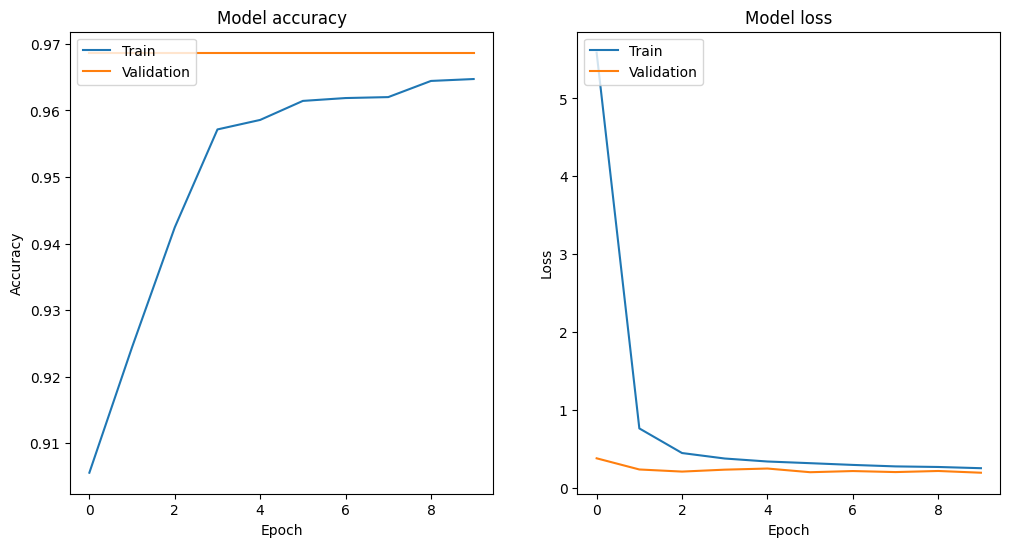

In [11]:
nb_epochs=10
batch_size=100
X_train = np.array(X_train, dtype=np.float32)
Y_train = np.array(Y_train, dtype=np.float32)
X_val = np.array(X_val, dtype=np.float32)
Y_val = np.array(Y_val, dtype=np.float32)
X_test = np.array(X_test, dtype=np.float32)
Y_test = np.array(Y_test, dtype=np.float32)

training_history = my_model_mlp.fit(X_train,Y_train,
                                    validation_data=(X_val, Y_val),
                                    epochs=nb_epochs,
                                    batch_size=batch_size)

#COMPUTE THE ACCURACY ON THE TRAINING AND TEST SETS
loss_train, acc_train = my_model_mlp.evaluate(X_train, Y_train, batch_size=batch_size)
loss_test, acc_test = my_model_mlp.evaluate(X_test, Y_test, batch_size=batch_size)

print("Performance on the TRAIN set, ACCURACY=",acc_train)
print("Performance on the TEST set, ACCURACY=",acc_test)
print("Performance on the TRAIN set, LOSS=",loss_train)
print("Performance on the TEST set, LOSS=",loss_test)   

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(training_history.history['accuracy'])
plt.plot(training_history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(training_history.history['loss'])
plt.plot(training_history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()


**QUESTION** Plot the confusion matrix and the classification report

**Tips:**

*   classification report link

> https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html

*   Matrix confusion

> https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html





47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
              precision    recall  f1-score   support

           0       0.97      1.00      0.99      1457
           1       0.00      0.00      0.00         8
           2       0.00      0.00      0.00        13
           3       0.00      0.00      0.00        11
           4       0.00      0.00      0.00        11

    accuracy                           0.97      1500
   macro avg       0.19      0.20      0.20      1500
weighted avg       0.94      0.97      0.96      1500



c:\Users\maure\OneDrive\Bureau\ISMIN\IA_manu_embarq\TP_IA_EMBARQUEE\myenv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\maure\OneDrive\Bureau\ISMIN\IA_manu_embarq\TP_IA_EMBARQUEE\myenv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\maure\OneDrive\Bureau\ISMIN\IA_manu_embarq\TP_IA_EMBARQUEE\myenv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` pa

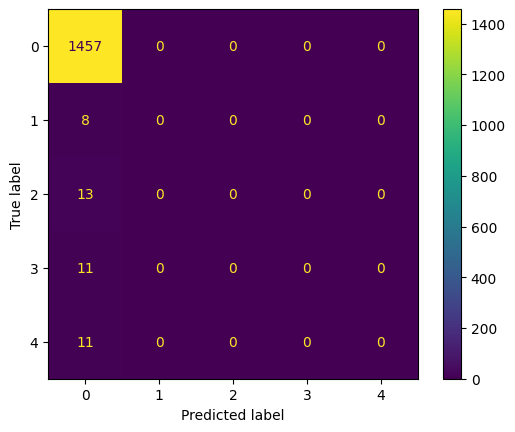

In [12]:
disp = ConfusionMatrixDisplay(confusion_matrix(Y_test.argmax(axis=1), my_model_mlp.predict(X_test).argmax(axis=1)))
disp.plot()
report = classification_report(Y_test.argmax(axis=1), my_model_mlp.predict(X_test).argmax(axis=1))
print(report)

**ANALYSIS QUESTION** What do you observe? What can you conclude?

Le modele ne parvient pas à prédire les labels. La précision lors du test reste tout de meme eleve puisque le pourcentage de machine failure par rapport au machine fonctionnant est tres faible. Le probleme vient du mauvais équilibrage des data et du trop faible nombre de data avec des failures.

## **3- Train model With balancing the dataset**

---

 Methods for rebalancing a dataset:


*   Use oversampling techniques (e.g., SMOTE) to generate synthetic data for minority classes


> https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html



*   Apply undersampling techniques (e.g., random undersampling, Tomek Links, Edited Nearest Neighbors) to reduce the majority class size



> https://imbalanced-learn.org/stable/references/generated/imblearn.under_sampling.RandomUnderSampler.html



*   Use class weighting during model training to penalize errors on minority classes



> https://www.tensorflow.org/tutorials/structured_data/imbalanced_data?hl=fr


**QUESTION:** Create X_train, Y_train, X_test, and Y_test. How many elements are present in X_train, Y_train, X_test, and Y_test? (Print the values)

In [14]:
df = pd.read_csv('./data/ai4i2020.csv')

df['Machine functional'] = 1 - df['Machine failure']

X = df.drop(columns=['Machine failure', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF'])
Y = df[['Machine functional', 'TWF', 'HDF', 'PWF', 'OSF']]
filtered_df = df[Y.sum(axis=1) == 1]
print(filtered_df.head())
X = filtered_df.drop(columns=['Machine failure', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF'])
Y = filtered_df[['Machine functional', 'TWF', 'HDF', 'PWF', 'OSF']]
X = pd.get_dummies(X)

# Convertir Y en un seul label catégorisé
def label_encoding(row):
    if row['Machine functional'] == 1:
        return 1
    elif row['TWF'] == 1:
        return 2
    elif row['HDF'] == 1:
        return 3
    elif row['PWF'] == 1:
        return 4
    elif row['OSF'] == 1:
        return 5
    return 0

Y_single_label = Y.apply(label_encoding, axis=1)

# Appliquer SMOTE
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_resampled, Y_resampled = smote.fit_resample(X, Y_single_label)

# Reconvertir Y en format one-hot encoding
Y_resampled_one_hot = np.zeros((Y_resampled.shape[0], 5))
Y_resampled_one_hot[np.arange(Y_resampled.shape[0]), Y_resampled - 1] = 1

# Split the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X_resampled, Y_resampled_one_hot, test_size=0.3, random_state=42)
X_val, X_test, Y_val, Y_test = train_test_split(X_test, Y_test, test_size=0.5, random_state=42)

# Print the number of elements in each set
print(f'Number of elements in X_train: {len(X_train)}')
print(f'Number of elements in Y_train: {len(Y_train)}')
print(f'Number of elements in X_test: {len(X_test)}')
print(f'Number of elements in Y_test: {len(Y_test)}')
print(f'Number of elements in X_val: {len(X_val)}')
print(f'Number of elements in Y_val: {len(Y_val)}')

   UDI Product ID Type  Air temperature [K]  Process temperature [K]  \
0    1     M14860    M                298.1                    308.6   
1    2     L47181    L                298.2                    308.7   
2    3     L47182    L                298.1                    308.5   
3    4     L47183    L                298.2                    308.6   
4    5     L47184    L                298.2                    308.7   

   Rotational speed [rpm]  Torque [Nm]  Tool wear [min]  Machine failure  TWF  \
0                    1551         42.8                0                0    0   
1                    1408         46.3                3                0    0   
2                    1498         49.4                5                0    0   
3                    1433         39.5                7                0    0   
4                    1408         40.0                9                0    0   

   HDF  PWF  OSF  RNF  Machine functional  
0    0    0    0    0               

c:\Users\maure\OneDrive\Bureau\ISMIN\IA_manu_embarq\TP_IA_EMBARQUEE\myenv\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Number of elements in X_train: 33813
Number of elements in Y_train: 33813
Number of elements in X_test: 7246
Number of elements in Y_test: 7246
Number of elements in X_val: 7246
Number of elements in Y_val: 7246


**ANALYSIS QUESTION:** Explain the choices you made to balance the dataset.

Comme expliqué précédement, certains labels sont peu présent, notre modèle ne peut donc pas bien s'entrainer pour prédire l'état des machines. Pour équilibrer la base de données, on commence par filtrer notre dataset en enlevant d'abord toutes les lignes pour lesquelles nos inputs ont plusieurs labels. Ensuite, on convertit Y en un seul label catégorisé car la fonction smote ne prend pas en charge les multilabels. On reconvertit ensuite Y pour retrouver nos labels pour l'entrainement.

On a décidé de faire du oversampling et pas du undersampling afin de garder un nombre important de data.

**QUESTION:** Code below the model architecture


**TIP:** It could be interesting to keep it the same as before

In [15]:
inputs = tf.keras.Input(shape=(X_train.shape[1],))
x = tf.keras.layers.Dense(512, activation='relu')(inputs)
x = tf.keras.layers.Dropout(0.2)(x)  # Dropout layer
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = Dense(5, activation='softmax')(x)

my_model_mlp = tf.keras.Model(inputs, outputs, name = 'my_model_mlp')
my_model_mlp.summary()
my_model_mlp.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


Model: "my_model_mlp"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 9978)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │     5,109,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,282,053 (20.15 MB)

 Trainable params: 5,282,053 (20.15 MB)

 Non-trainable params: 0 (0.00 B)

**QUESTION** Code below the algorithms allowing to train model


Epoch 1/10
339/339 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - accuracy: 0.2469 - loss: 6.8825 - val_accuracy: 0.4060 - val_loss: 1.3725
Epoch 2/10
339/339 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - accuracy: 0.3936 - loss: 1.3863 - val_accuracy: 0.5813 - val_loss: 1.0461
Epoch 3/10
339/339 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - accuracy: 0.5590 - loss: 1.0433 - val_accuracy: 0.8271 - val_loss: 0.4720
Epoch 4/10
339/339 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - accuracy: 0.7593 - loss: 0.6652 - val_accuracy: 0.8816 - val_loss: 0.3443
Epoch 5/10
339/339 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - accuracy: 0.8418 - loss: 0.4667 - val_accuracy: 0.9144 - val_loss: 0.2404
Epoch 6/10
339/339 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - accuracy: 0.8745 - loss: 0.3772 - val_accuracy: 0.9302 - val_loss: 0.1853
Epoch 7/10
339/339 ━━━━━━━━━━━━━━━━━━━━ 11s 32ms/step - accuracy: 0.8870 - loss: 0.3407 - val_accuracy: 0.9389 - val_loss: 0.1953
Epoch 8/10
339/339 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - accuracy: 0.9135 - loss: 0.2625 - 

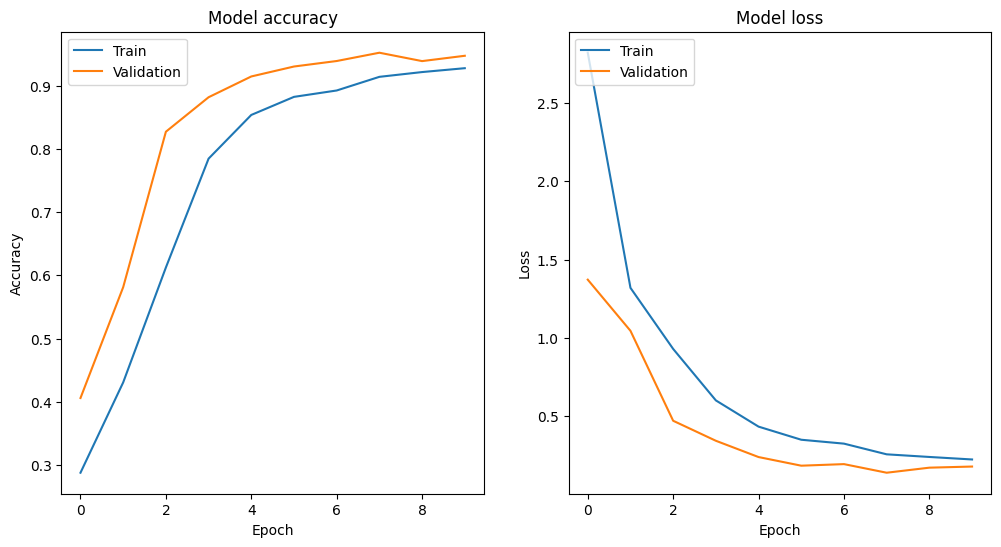

In [16]:
nb_epochs=10
batch_size=100
X_train = np.array(X_train, dtype=np.float32)
Y_train = np.array(Y_train, dtype=np.float32)
X_val = np.array(X_val, dtype=np.float32)
Y_val = np.array(Y_val, dtype=np.float32)
X_test = np.array(X_test, dtype=np.float32)
Y_test = np.array(Y_test, dtype=np.float32)

training_history = my_model_mlp.fit(X_train,Y_train,
                                    validation_data=(X_val, Y_val),
                                    epochs=nb_epochs,
                                    batch_size=batch_size)

#COMPUTE THE ACCURACY ON THE TRAINING AND TEST SETS
loss_train, acc_train = my_model_mlp.evaluate(X_train, Y_train, batch_size=batch_size)
loss_test, acc_test = my_model_mlp.evaluate(X_test, Y_test, batch_size=batch_size)

print("Performance on the TRAIN set, ACCURACY=",acc_train)
print("Performance on the TEST set, ACCURACY=",acc_test)
print("Performance on the TRAIN set, LOSS=",loss_train)
print("Performance on the TEST set, LOSS=",loss_test)   

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(training_history.history['accuracy'])
plt.plot(training_history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(training_history.history['loss'])
plt.plot(training_history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()


**QUESTION** Plot the confusion matrix and the classification report

227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
              precision    recall  f1-score   support

           0       0.95      0.85      0.90      1512
           1       0.87      1.00      0.93      1384
           2       0.93      1.00      0.96      1411
           3       0.99      0.90      0.94      1457
           4       1.00      0.98      0.99      1482

    accuracy                           0.94      7246
   macro avg       0.95      0.95      0.94      7246
weighted avg       0.95      0.94      0.94      7246



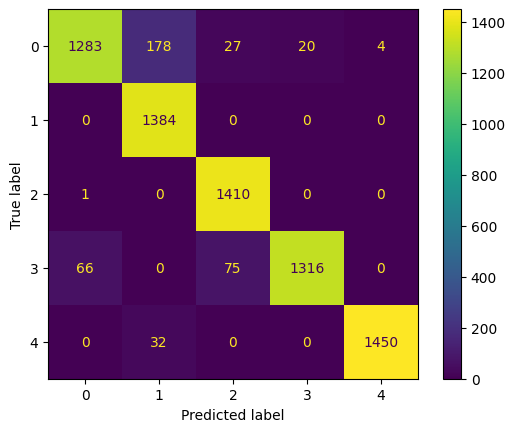

In [17]:
disp = ConfusionMatrixDisplay(confusion_matrix(Y_test.argmax(axis=1), my_model_mlp.predict(X_test).argmax(axis=1)))
disp.plot()
report = classification_report(Y_test.argmax(axis=1), my_model_mlp.predict(X_test).argmax(axis=1))
print(report)

**ANALYSIS QUESTION** What do you observe? What can you conclude?

Avec notre dataset rééquilibré, on observe sur la matrice de confusion qu'on arrive à prédire correctement les labels. Le modèle a donc réussit cette fois-ci à s'entrainer avec notre dataset rééquilibré.

In [19]:
#save the model to tflite
converter = tf.lite.TFLiteConverter.from_keras_model(my_model_mlp)
tflite_model = converter.convert()
open("neural_network.tflite", "wb").write(tflite_model)

#reduce the size of the data and save it
X_test = X_test[0:1000]
Y_test = Y_test[0:1000]

np.save('data/X_test.npy', X_test)
np.save('data/Y_test.npy', Y_test)

INFO:tensorflow:Assets written to: C:\Users\maure\AppData\Local\Temp\tmpo9rzycd2\assets


INFO:tensorflow:Assets written to: C:\Users\maure\AppData\Local\Temp\tmpo9rzycd2\assets


Saved artifact at 'C:\Users\maure\AppData\Local\Temp\tmpo9rzycd2'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 9978), dtype=tf.float32, name='keras_tensor_8')
Output Type:
  TensorSpec(shape=(None, 5), dtype=tf.float32, name=None)
Captures:
  2924032032256: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2922794484128: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2922815843136: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2922815843312: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2923942098896: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2923942098720: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2922946651584: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2922946651408: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2922946561296: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2922946561120: TensorSpec(shape=(), dtype=tf.resource, name=None)
